In [1]:
from prepare_pdbbind import pdb_ignore_list
from prepare_pdbbind import defined_interactions

import pandas as pd

max_size = 1

df = pd.read_csv('LP_PDBBind.csv', index_col=0)
train_pdbs = [ x for x in list(df[(df['new_split'] == 'train') & df.CL1 & ~df.covalent].index) if x not in pdb_ignore_list ][:max_size]
test_pdbs = [ x for x in list(df[(df['new_split'] == 'test') & df.CL1 & ~df.covalent].index) if x not in pdb_ignore_list ][:max_size]
val_pdbs = [ x for x in list(df[(df['new_split'] == 'val') & df.CL1 & ~df.covalent].index) if x not in pdb_ignore_list ][:max_size]

In [2]:

from torch import nn

config = {
    "radius": 7.5,
    
    "basis_density_per_A": 5,

    "out_scalars": 1,
    "out_vectors": 0,
    "out_tensors": 0,

    "spherical_harmonics_l": 2,

    "node_embedding_scalars": 8,
    "node_embedding_vectors": 1,
    "node_embedding_tensors": 1,

    "interaction_tp_lig_weights_hidden_layers":[24],
    "interaction_tp_rec_weights_hidden_layers":[24],
    "interaction_tp_lig_weights_act": nn.ReLU(),
    "interaction_tp_rec_weights_act": nn.ReLU(),

    "n_pattern_layers": 2,

    "node_emb_hidden_layers": [24],
    "node_emb_act": None,

    "batch_normalize_msg": True,
    "batch_normalize_node_upd": False,

    "msg_weights_hidden_layers": [24],
    "msg_weights_act": nn.ReLU(),

    "node_update_hidden_layers": [24],
    "node_update_act": None,
}

In [3]:

import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [4]:
import train
from torch import nn
from data import PDBBindInteractionDataset
from torch.utils.data import DataLoader
from models.InteractionPredictor import InteractionPredictor

import warnings
warnings.filterwarnings("ignore")

['hbond', 'pistacking', 'hydrophobic', 'pication', 'saltbridges', 'halogenbond']
for interaction_type in ['hydrophobic']:
    print("@@@@ ", interaction_type)
    inter_pred = InteractionPredictor(config)
    print("Model weights:", sum(p.numel() for p in inter_pred.parameters() if p.requires_grad))

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(inter_pred.parameters(), lr=1e-3, amsgrad=True)

    dataset_train = PDBBindInteractionDataset("pdbbind2020/", train_pdbs, interaction_type)
    dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=dataset_train.collate_fn, pin_memory=True, num_workers=1)
    dataset_test = PDBBindInteractionDataset("pdbbind2020/", test_pdbs, interaction_type)
    dataloader_test = DataLoader(dataset_test, batch_size=4, shuffle=True, collate_fn=dataset_test.collate_fn, pin_memory=True, num_workers=1)

    print("Training size:", len(dataset_train), "Test size:", len(dataset_test))

    train.train(1, 1, dataloader_train, dataloader_test, inter_pred, loss_fn, optimizer, save_weights=False, device="cpu")
    print("\n-------------------------------------------------------------\n")

@@@@  hydrophobic
Model weights: 12542
Training size: 1 Test size: 1
loss: 0.8152824044  recall:  20.83%  precision:  12.20%  [    1/    1]
####  eval set loss: 0.6892117858  recall:   0.00%  precision:   0.00%

-------------------------------------------------------------



In [5]:
from e3nn import o3
from torch_geometric.data import Data

inter_pred = InteractionPredictor(config)

rot = o3.rand_matrix()

dataset_train = PDBBindInteractionDataset("pdbbind2020/", train_pdbs, interaction_type)
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=dataset_train.collate_fn, pin_memory=True, num_workers=1)
for g in dataloader_train:
    break

print(g)

g_rot = Data.clone(g)
g_rot.pos = g_rot.pos @ rot.T

print(g_rot)

# rotate before
f_before, edges = inter_pred(g_rot)

# rotate after
f_after, edges = inter_pred(g, edges)

torch.allclose(f_before, f_after, rtol=1e-4, atol=1e-4)

Data(x=[891, 11], edge_index=[2, 1692], edge_attr=[1692, 4], y=[24, 2], pos=[891, 3], pdb=[1], n_rec_nodes=[1], n_lig_nodes=[1])
Data(x=[891, 11], edge_index=[2, 1692], edge_attr=[1692, 4], y=[24, 2], pos=[891, 3], pdb=[1], n_rec_nodes=[1], n_lig_nodes=[1])


True

In [37]:
# analysis of kd and ki values

df = pd.read_csv('LP_PDBBind.csv', index_col=0)
kdki_pdbs = [ x for x in list(df[df.CL2 & ~df.covalent].index) if x not in pdb_ignore_list ]
df.loc[kdki_pdbs][["value"]].values

array([[8.22],
       [7.6 ],
       [9.64],
       ...,
       [7.28],
       [7.23],
       [2.68]])

In [6]:
from e3nn import o3

irreps_node_in = o3.Irreps( "8x0e")
irreps_message = o3.Irreps("8x0e + 1x1o + 1x2e")
irreps_node_out = o3.Irreps("8x0e + 1x1o + 1x2e")
irreps_out = o3.Irreps("1x0e")
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)

e3tp_message_initial = o3.FullyConnectedTensorProduct(irreps_node_in,
                                              irreps_sh,
                                              irreps_message, 
                                              shared_weights=False)

e3tp_message = o3.FullyConnectedTensorProduct(irreps_node_out,
                                              irreps_sh,
                                              irreps_message, 
                                              shared_weights=False)

e3tp_node_update_initial = o3.FullyConnectedTensorProduct(irreps_node_in,
                                                  irreps_message, 
                                                  irreps_node_out,
                                                  shared_weights=False)

e3tp_node_update = o3.FullyConnectedTensorProduct(irreps_node_out,
                                                  irreps_message, 
                                                  irreps_node_out,
                                                  shared_weights=False)

e3tp_interaction = o3.FullyConnectedTensorProduct(irreps_node_out + irreps_sh, irreps_node_out, irreps_out, shared_weights=False)

FullyConnectedTensorProduct(8x0e x 1x0e+1x1o+1x2e -> 8x0e+1x1o+1x2e | 80 paths | 80 weights)

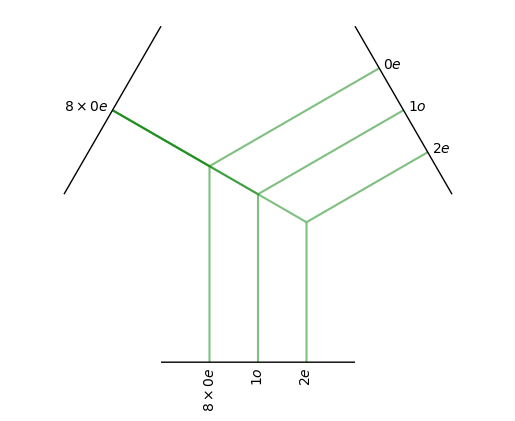

In [7]:
e3tp_message_initial.visualize()
e3tp_message_initial

FullyConnectedTensorProduct(8x0e x 8x0e+1x1o+1x2e -> 8x0e+1x1o+1x2e | 528 paths | 528 weights)

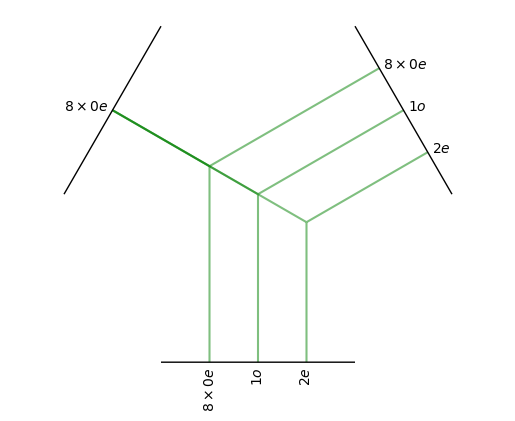

In [8]:
e3tp_node_update_initial.visualize()
e3tp_node_update_initial

FullyConnectedTensorProduct(8x0e+1x1o+1x2e x 1x0e+1x1o+1x2e -> 8x0e+1x1o+1x2e | 102 paths | 102 weights)

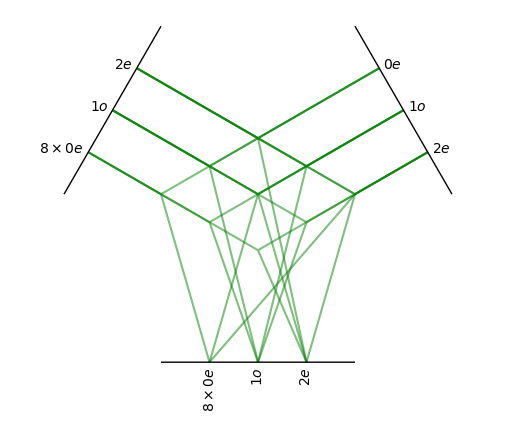

In [9]:
e3tp_message.visualize()
e3tp_message

FullyConnectedTensorProduct(8x0e+1x1o+1x2e x 8x0e+1x1o+1x2e -> 8x0e+1x1o+1x2e | 564 paths | 564 weights)

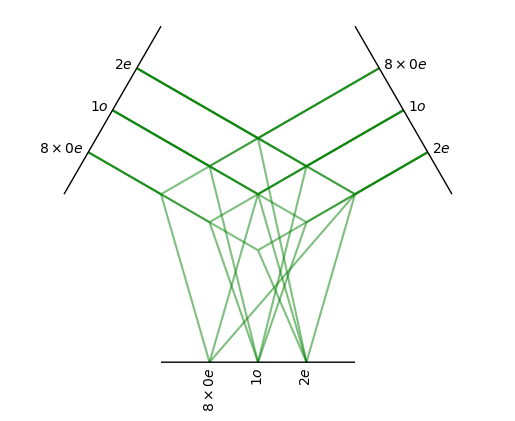

In [10]:
e3tp_node_update.visualize()
e3tp_node_update

FullyConnectedTensorProduct(8x0e+1x1o+1x2e+1x0e+1x1o+1x2e x 8x0e+1x1o+1x2e -> 1x0e | 76 paths | 76 weights)

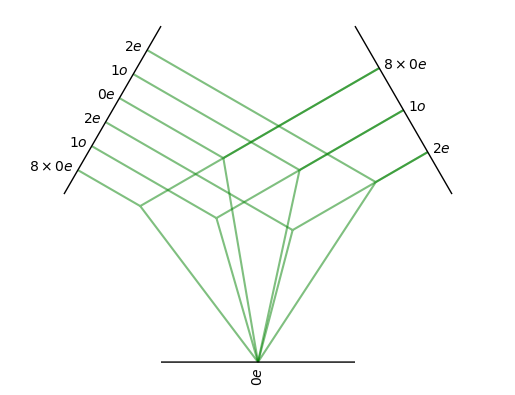

In [11]:
e3tp_interaction.visualize()
e3tp_interaction